## Main Objective
To predict the loan risk or quality (loan repayment) on a given applicant. Particularly, we would like to assess on the loans that are funded as MoneyLion are practically exposed to the risk on the loans that are funded. Approval of loans can mostly tell the credit rating of an applicant of which we can use as a feature. 

In [1]:
import pandas as pd
from google.colab import drive
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Run this line only if data is stored on google drive/colab
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Importing the data sets as dataframes
loan_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MoneyLion DS Assessment/data/data/loan.csv', parse_dates=['applicationDate', 'originatedDate'])
payment_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MoneyLion DS Assessment/data/data/payment.csv')
cuv_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MoneyLion DS Assessment/data/data/clarity_underwriting_variables.csv')


<ipython-input-2-2ee1f8c977a2>:4: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  cuv_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MoneyLion DS Assessment/data/data/clarity_underwriting_variables.csv')


## loan.csv dataset

- We would first take a look at the `loan.csv` file. The first assumption that is made is that MoneyLion is only exposed to the risk where the loan has been funded, hence the loans that were ultimately not funded will be filtered out.

- Among the features in the `loan.csv` dataset, the `loanStatus` allows us to classify loans into different levels and also filter out rows of dataset that may not contribute in the assessment of risk level.

In [3]:
# Consider only funded loans
loan_heads = loan_df.columns
loan_funded = loan_df[loan_df['isFunded'] == 1]
loan_heads, loan_funded['loanStatus'].value_counts(normalize=True)

(Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
        'originated', 'originatedDate', 'nPaidOff', 'approved', 'isFunded',
        'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state',
        'leadType', 'leadCost', 'fpStatus', 'clarityFraudId', 'hasCF'],
       dtype='object'),
 Paid Off Loan                  0.293135
 External Collection            0.290750
 New Loan                       0.208096
 Internal Collection            0.142733
 Returned Item                  0.030322
 Settlement Paid Off            0.018162
 Settled Bankruptcy             0.008337
 Pending Paid Off               0.004335
 Charged Off Paid Off           0.004079
 Charged Off                    0.000026
 Settlement Pending Paid Off    0.000026
 Name: loanStatus, dtype: float64)

As we have the funding data (on if a loan is ultimately funded or not) in the `isFunded` column, we can filter out the loans that were ultimately not funded (i.e. MoneyLion is not exposed to any risk if loan is not funded). This leaves us with debts that are qualitatively categorized in the manner as below:

*Certain Good debt*
- **Paid Off Loan:** Loans that are ultimately paid off. Lowest Risk

*Possible good debt*
- **Settlement Paid Off:** Borrower and lender agrees to settle at a lower amount than the outstanding balance. Risk increases but still managed to recover.


*Gray area*
- **External Collection:** Unsecured loans that has no collateral tied. These loans are sent to third-party debt collection agency for collection. When defaulted, MoneyLion needs to sell of this loan to the 3rd party agency at a discount, which lowers the credit score of the borrower. However, it does not necessarily mean that it is a bad loan.
- **New Loan**: Pretty much undefined 
- **Internal Collection:** Similar to external collection, but now MoneyLion is responsible to query and collect loans.
- **Pending Paid Off:** Payment has yet been processed but borrower has made progress. Cannot particularly be defined as it has not resulted in anything
- **Settlement Pending Paid Off:** Again pending means that nothing can be said about this status.

*Possible Bad Debt*
- **Returned Item:** Missed one payment due to insufficient funding
- **Charged Off Paid Off:** Loan has been written off as a bad loan but however has been paid off. Typically means that you have a difficulty in paying off your loans

*Certain Bad debt*
- **Settled Bankruptcy:** Basically bankrupt
- **Charged Off:** Written off as uncollectible

From here, we can disregard the data from that falls under that *Gray area* and focus on the rest of the data. We can separate them in different labelled classes that categorizes them into increasing risk levels:

0. Paid Off Loan
1. Settlement Paid Off
2. Returned Item, Charged Off Paid Off
3. Settled Bankruptcy, Charged Off


In [4]:
# Risk levels (Higher number means lower risk)
global risk_labels 
risk_labels = {
    0: ['Paid Off Loan'],
    1: ['Settlement Paid Off'],
    2: ['Returned Item', 'Charged Off Paid Off'],
    3: ['Settled Bankruptcy', 'Charged Off']
          }


def map_labels(x: str):
  for key, ele in risk_labels.items():
    if x in ele:
      return key

In [5]:
# Assigning a new column which classifies the data into classes
y_col_name = 'risk level'
loan_funded[y_col_name] = loan_funded['loanStatus'].map(map_labels)

# Removing the data points that we are not able to classify them
loan_funded_wclass = loan_funded[loan_funded[y_col_name].notna()].reset_index(drop=True)
loan_funded_wclass[y_col_name] = loan_funded_wclass[y_col_name].astype(int)

<ipython-input-5-1efda55caf03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_funded[y_col_name] = loan_funded['loanStatus'].map(map_labels)


In [6]:
loan_funded_wclass.value_counts('risk level')

risk level
0    11427
2     1341
1      708
3      326
dtype: int64

In [7]:
loan_funded_wclass.columns

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'originated', 'originatedDate', 'nPaidOff', 'approved', 'isFunded',
       'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state',
       'leadType', 'leadCost', 'fpStatus', 'clarityFraudId', 'hasCF',
       'risk level'],
      dtype='object')

Amongest the columns in the `loan.csv` file, only a few of the features can be quantified and are correlated to the risk levels. Intuitively, it includes `payFrequency, apr, leadType, nPaidOff, loanAmount, originallyScheduledPaymentAmount, state, leadType, leadCost, fpStatus`. Among these features, some of them have direct correlations such as `leadType` directly reflecting the amount of `leadCost` needed. Other than that, we can filter out the other columns that are not to be used.

In [8]:
# Probability distribution of each classes
prob_0 = loan_funded[y_col_name].value_counts(normalize=True)[0]
prob_1 = loan_funded[y_col_name].value_counts(normalize=True)[1]
prob_2 = loan_funded[y_col_name].value_counts(normalize=True)[2]
prob_3 = loan_funded[y_col_name].value_counts(normalize=True)[3]
prob_0, prob_1, prob_2, prob_3

(0.8279234893493697,
 0.051296913490798436,
 0.09715983190841906,
 0.02361976525141284)

# Furthur exploration of data

In this section, we will explore the dataset that will be used to train our machine learning model. We would explore the relationship between variables and attempt to clean and prepare the data set for the training of the model. We would also attempt to join useful informations in the `payment.csv` and `clarity_underwriting_variables.csv` file.

In [9]:
# Checking if any columns has null values
loan_funded_wclass.isna().sum(axis=0)

loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
applicationDate                        0
originated                             0
originatedDate                         0
nPaidOff                               7
approved                               0
isFunded                               0
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
fpStatus                               0
clarityFraudId                      2711
hasCF                                  0
risk level                             0
dtype: int64

In [10]:
# Cleaning the dataset by inserting 0 where number of loans paid off is undefined
loan_funded_wclass['nPaidOff'] = loan_funded_wclass['nPaidOff'].fillna(0)

In [11]:
# Statistical detail of numerical columns
loan_funded_wclass.describe()

,apr,nPaidOff,isFunded,loanAmount,originallyScheduledPaymentAmount,leadCost,hasCF,risk level
count,13802.000000,13802.000000,13802.0,13802.000000,13802.000000,13802.000000,13802.000000,13802.000000
mean,511.316246,0.556876,1.0,632.987248,1680.861487,12.476090,0.803579,0.316476
std,119.584548,1.346925,0.0,450.471573,1206.973028,24.250406,0.397305,0.743234
min,0.000000,0.000000,1.0,100.000000,188.410000,0.000000,0.000000,0.000000
25%,390.000000,0.000000,1.0,350.000000,970.102500,0.000000,1.000000,0.000000
50%,590.000000,0.000000,1.0,500.000000,1329.390000,3.000000,1.000000,0.000000
75%,590.000000,1.000000,1.0,700.000000,1965.222500,10.000000,1.000000,0.000000
max,705.590000,21.000000,1.0,4687.000000,12550.080000,200.000000,1.000000,3.000000


In [12]:
# Statistical details of each columns of the data set
identifications = ['loanId', 'anon_ssn', 'clarityFraudId']

for ele in loan_funded_wclass.columns.difference(identifications):
  print(ele)
  print('-'*100)
  if loan_funded_wclass[ele].dtype != 'object':
    print(loan_funded_wclass.groupby('risk level')[ele].describe(percentiles=[.25, .5, .75, .9, .99]))
    print('*'*100)
  else:
    print(loan_funded_wclass.groupby('risk level')[ele].value_counts(normalize=True, ascending=False, sort=True).unstack())
    print('*'*100)

applicationDate
----------------------------------------------------------------------------------------------------
            count unique                         top freq  \
risk level                                                  
0           11427  11426  2015-02-20 17:16:24.718000    2   
1             708    708  2015-10-18 23:09:25.326000    1   
2            1341   1341  2016-12-01 23:00:52.969000    1   
3             326    326  2016-08-30 07:24:47.381000    1   

                                 first                        last  
risk level                                                          
0           2014-12-03 00:47:06.203000  2017-03-18 23:34:27.369000  
1           2014-12-03 00:31:22.306000  2017-03-06 06:00:54.819000  
2           2014-12-06 13:43:29.653000  2017-03-18 23:38:50.917000  
3           2015-02-13 18:35:34.286000  2017-03-17 20:49:59.334000  
****************************************************************************************************
a

<ipython-input-12-559a387cbac7>:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(loan_funded_wclass.groupby('risk level')[ele].describe(percentiles=[.25, .5, .75, .9, .99]))
<ipython-input-12-559a387cbac7>:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(loan_funded_wclass.groupby('risk level')[ele].describe(percentiles=[.25, .5, .75, .9, .99]))
<ipython-input-12-559a387cbac7>:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence 

loanStatus  Charged Off  Charged Off Paid Off  Paid Off Loan  Returned Item  \
risk level                                                                    
0                   NaN                   NaN            1.0            NaN   
1                   NaN                   NaN            NaN            NaN   
2                   NaN              0.118568            NaN       0.881432   
3              0.003067                   NaN            NaN            NaN   

loanStatus  Settled Bankruptcy  Settlement Paid Off  
risk level                                           
0                          NaN                  NaN  
1                          NaN                  1.0  
2                          NaN                  NaN  
3                     0.996933                  NaN  
****************************************************************************************************
nPaidOff
-------------------------------------------------------------------------------------------

<ipython-input-12-559a387cbac7>:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(loan_funded_wclass.groupby('risk level')[ele].describe(percentiles=[.25, .5, .75, .9, .99]))
<ipython-input-12-559a387cbac7>:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(loan_funded_wclass.groupby('risk level')[ele].describe(percentiles=[.25, .5, .75, .9, .99]))
<ipython-input-12-559a387cbac7>:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence 

From the statistics above, few interesting observations can be made:
1. In most of the dataset, the standard deviation `std` between risk levels can be significantly different implying that each feature contains certain level of bias towards certain risk levels. The assumption here is that the trade-off will be balanced off between different features.

2. For `fpStatus` feature, most of the first payments were marked as `Checked` regardless of the risk level. Hence, the hypothesis here is that the risk level is not to be highly dependent on only the first payment of the loan.

3. For `leadType`, `bvMandatory` takes up the highest proportions in all risk levels except for risk level 2. This implies that MoneyLion has taken precautionary steps in performing bank verification before a loan approval indicating most loans that are approved have good credit scores from the banks.

4. `payFrequency` shows that most clients are prone to bi-weekly payments regardless of the risk levels.

5. For `state`, it shows the distribution of risk in geometrical locations, where loans located in certain states may have higher risk. This comes down to many factors such as population density, asset allocation, weather conditions, aand other demographic factors that can affect the borrowers' ability to pay loan.



# clarity_underwriting_variables dataset

Combining the information from `clarity_underwriting_variables.csv` file. After the join is done we can remove the `clarityFraudId` and `underwritingid`

In [13]:
# Joining the clarity_underwriting_variables.csv
loan_funded_cuv = pd.merge(
    left=loan_funded_wclass, 
    right=cuv_df[['underwritingid', 'clearfraudscore']],
    left_on='clarityFraudId',
    right_on='underwritingid',
    how='left')
loan_funded_cuv.head(6)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,risk level,underwritingid,clearfraudscore
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0,569eb3a3e4b096699f685d64,879.0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,3313.78,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,58450a15e4b0bb9d6d7344c7,835.0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,2432.08,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,0,578f9346e4b0810ad5e7b72e,624.0
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,422.64,WI,organic,0,Checked,56621584e4b0100e84141586,1,0,56621584e4b0100e84141586,770.0
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,896.87,MO,bvMandatory,6,Rejected,NaN,0,0,NaN,NaN
5,LL-I-04577739,edac6e371cda7512214ba74698247a19,B,601.0,2015-11-12 21:07:03.953,True,2015-11-12 21:57:28.345,0.0,True,1,...,1616.20,SC,lead,10,Checked,557716a4e4b0a648a068ade3,1,0,557716a4e4b0a648a068ade3,818.0


<Axes: xlabel='nPaidOff', ylabel='clearfraudscore'>

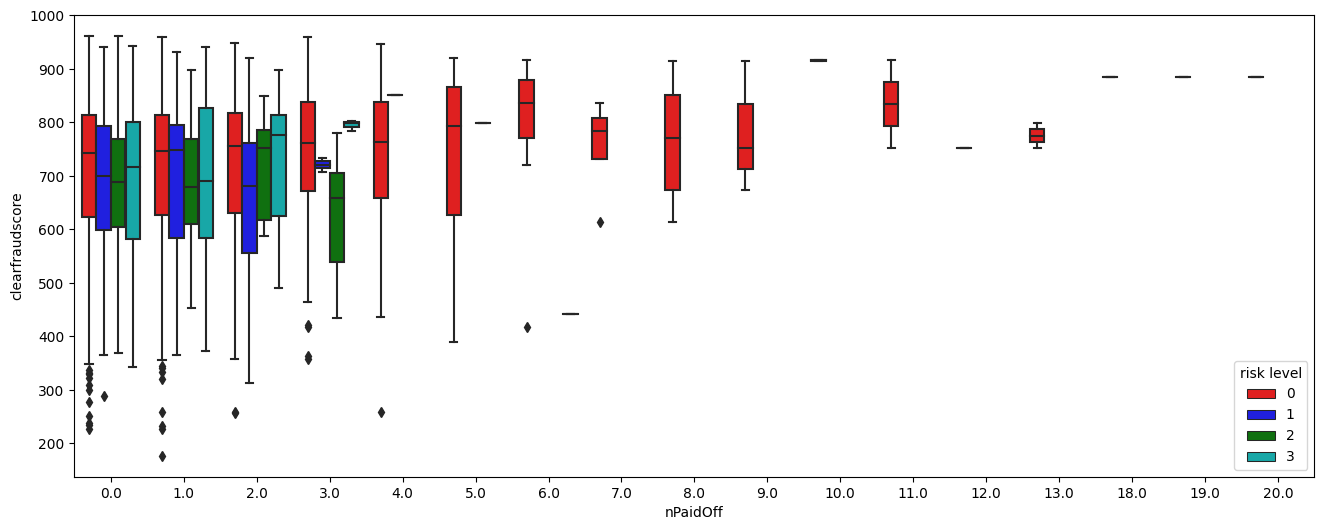

In [14]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="nPaidOff", y="clearfraudscore",
            hue="risk level", palette=["r", "b", "g", "c"],
            data=loan_funded_cuv[loan_funded_cuv['clearfraudscore'].notna()])

- From the figure above, it can generally be deduced that the more loans taht are paid off leads to a higher median of `clearfraudscore`. However, it can be seen at the early stages, the median of increasing risk levels do not imply higher clear fraud score, thus we may see a lower weight for lower number of `nPaidOff` in our machine learning model. 
- Next, as we can identify the individual with `anon_ssn` by assuming it is actually their social security number, we can aggregate the rows to find the number of loans per individual according to their `anon_ssn`. 
- We can then also find the period from application to ultimate funding of a loan by using the difference between `originatedDate`  and `applicationDate`.

In [15]:
# New column that shows the number of loan per anon_ssn 
loan_funded_cuv['loan_per_ssn'] = loan_funded_cuv['anon_ssn'].map(loan_funded_cuv.groupby('anon_ssn')['loanId'].count())
loan_funded_cuv.head(5)

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,risk level,underwritingid,clearfraudscore,loan_per_ssn
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0,569eb3a3e4b096699f685d64,879.0,1
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,MO,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,58450a15e4b0bb9d6d7344c7,835.0,4
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,CA,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,0,578f9346e4b0810ad5e7b72e,624.0,1
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,WI,organic,0,Checked,56621584e4b0100e84141586,1,0,56621584e4b0100e84141586,770.0,3
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,MO,bvMandatory,6,Rejected,NaN,0,0,NaN,NaN,1


In [16]:
# Adding a new column that shows how long it takes to fund a loan in hours
print(loan_funded_cuv['originatedDate'] - loan_funded_cuv['applicationDate'])
loan_funded_cuv['origin_day'] = loan_funded_cuv['originatedDate'].dt.day
loan_funded_cuv['accepted_day'] = loan_funded_cuv['applicationDate'].dt.day
loan_funded_cuv['time_for_funding'] = (loan_funded_cuv['originatedDate'] - loan_funded_cuv['applicationDate']).astype('timedelta64[h]').astype(int)

0       0 days 17:41:42.068000
1       0 days 00:11:57.139000
2       2 days 05:56:58.572000
3       0 days 12:06:17.411000
4       0 days 01:43:20.712000
                 ...          
13797   0 days 00:15:09.025000
13798   0 days 00:30:32.641000
13799   0 days 00:17:01.741000
13800   0 days 20:36:04.249000
13801   0 days 02:54:36.717000
Length: 13802, dtype: timedelta64[ns]


In [17]:
# Paid off loans per individual
loan_funded_cuv['paid_off_loans'] = loan_funded_cuv['anon_ssn'].map(loan_funded.groupby('anon_ssn')['nPaidOff'].sum()).astype(int)

In [18]:
loan_funded_cuv.columns

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'originated', 'originatedDate', 'nPaidOff', 'approved', 'isFunded',
       'loanStatus', 'loanAmount', 'originallyScheduledPaymentAmount', 'state',
       'leadType', 'leadCost', 'fpStatus', 'clarityFraudId', 'hasCF',
       'risk level', 'underwritingid', 'clearfraudscore', 'loan_per_ssn',
       'origin_day', 'accepted_day', 'time_for_funding', 'paid_off_loans'],
      dtype='object')

In [19]:
# Dropping the features/columns that were deemed as not useful for our training and analysis
unused_cols = [
    'anon_ssn', 'applicationDate', 'originated', 
    'originatedDate', 'approved', 'isFunded',
    'loanStatus', 'clarityFraudId', 'hasCF', 'underwritingid']
loan_funded_cuv = loan_funded_cuv.drop(unused_cols, axis=1)
loan_funded_cuv.columns

Index(['loanId', 'payFrequency', 'apr', 'nPaidOff', 'loanAmount',
       'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost',
       'fpStatus', 'risk level', 'clearfraudscore', 'loan_per_ssn',
       'origin_day', 'accepted_day', 'time_for_funding', 'paid_off_loans'],
      dtype='object')

In [20]:
from sklearn import preprocessing


# Encoding the columns that are in data type 'str'
cols_to_encode = ['payFrequency', 'state', 'leadType', 'fpStatus']

for ele in cols_to_encode:
  encoder = preprocessing.LabelEncoder()
  loan_funded_cuv[ele + '_encoded'] = encoder.fit_transform(loan_funded_cuv[ele])
  loan_funded_cuv = loan_funded_cuv.drop(ele, axis=1)
loan_funded_cuv.columns

Index(['loanId', 'apr', 'nPaidOff', 'loanAmount',
       'originallyScheduledPaymentAmount', 'leadCost', 'risk level',
       'clearfraudscore', 'loan_per_ssn', 'origin_day', 'accepted_day',
       'time_for_funding', 'paid_off_loans', 'payFrequency_encoded',
       'state_encoded', 'leadType_encoded', 'fpStatus_encoded'],
      dtype='object')

# payment.csv dataset

In [21]:
# Counting the payment status per each loadId to understand their payment behaviours
payment_df['val'] = 1
payment_status = payment_df.pivot_table(index=['loanId'], columns=['paymentStatus'], values='val', aggfunc=sum, fill_value=0)
payment_status = payment_status.fillna(0).reset_index()
payment_status

paymentStatus,loanId,Cancelled,Checked,Complete,None,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped
0,LL-I-00000021,0,12,0,0,0,1,0,0,0
1,LL-I-00000231,8,2,0,8,0,2,0,0,0
2,LL-I-00000238,4,7,0,4,0,1,0,0,0
3,LL-I-00000308,10,1,0,10,0,1,0,0,0
4,LL-I-00000355,11,0,0,11,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
39947,LP-I-00000127,0,12,0,0,0,0,0,0,0
39948,LP-I-00000134,6,1,0,0,0,0,0,0,0
39949,LP-I-00000139,0,12,0,0,0,3,0,0,0
39950,LP-I-00000142,12,0,0,0,0,0,0,0,1


In [22]:
# Obtaining full dataset to be used in machine learning model
full_df = pd.merge(left=loan_funded_cuv, right=payment_status, on='loanId', how='inner')
full_data_df = full_df.drop('loanId', axis=1)
full_data_df

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,risk level,clearfraudscore,loan_per_ssn,origin_day,accepted_day,...,fpStatus_encoded,Cancelled,Checked,Complete,None,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped
0,199.0,0.0,3000.0,6395.19,0,0,879.0,1,20,19,...,1,3,22,0,0,0,0,0,0,0
1,490.0,2.0,1250.0,3313.78,0,0,835.0,4,31,31,...,1,12,1,0,0,0,0,0,0,0
2,590.0,0.0,800.0,2432.08,10,0,624.0,1,29,27,...,1,0,13,0,0,0,0,0,0,0
3,404.1,3.0,300.0,422.64,0,0,770.0,3,25,25,...,1,21,6,0,0,0,0,0,0,0
4,590.0,0.0,300.0,896.87,6,0,NaN,1,26,26,...,2,21,3,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13790,180.2,0.0,500.0,794.60,25,2,695.0,1,21,21,...,2,0,0,0,6,0,0,0,0,0
13791,565.0,3.0,600.0,1670.18,0,0,NaN,1,1,1,...,1,11,3,0,0,0,0,0,0,0
13792,645.0,0.0,375.0,1042.40,25,0,700.0,1,14,14,...,1,6,1,0,0,0,0,0,0,0
13793,449.0,0.0,400.0,664.12,40,0,806.0,1,22,22,...,1,0,13,0,0,0,0,0,0,0


# Machine Learning models

In [23]:
from  sklearn.model_selection import train_test_split
from sklearn import svm

In [24]:
data = full_data_df.copy()
data.head(5)

,apr,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,risk level,clearfraudscore,loan_per_ssn,origin_day,accepted_day,...,fpStatus_encoded,Cancelled,Checked,Complete,None,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped
0,199.0,0.0,3000.0,6395.19,0,0,879.0,1,20,19,...,1,3,22,0,0,0,0,0,0,0
1,490.0,2.0,1250.0,3313.78,0,0,835.0,4,31,31,...,1,12,1,0,0,0,0,0,0,0
2,590.0,0.0,800.0,2432.08,10,0,624.0,1,29,27,...,1,0,13,0,0,0,0,0,0,0
3,404.1,3.0,300.0,422.64,0,0,770.0,3,25,25,...,1,21,6,0,0,0,0,0,0,0
4,590.0,0.0,300.0,896.87,6,0,NaN,1,26,26,...,2,21,3,0,0,0,1,0,0,0


In [25]:
# Check if there are any null values in each column before data is used for training
for ele in data.columns:
  if data[ele].isna().values.any():
    print(ele, data[ele].isna().value_counts(), data[ele].isna().value_counts(True))

clearfraudscore False    11034
True      2761
Name: clearfraudscore, dtype: int64 False    0.799855
True     0.200145
Name: clearfraudscore, dtype: float64


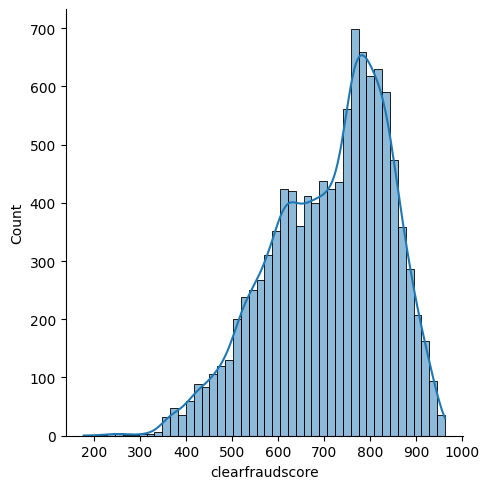

In [26]:
# To determine how we should further clean this column we need to understand the nature of this feature
sns.displot(data.loc[data['clearfraudscore'].notna(), 'clearfraudscore'], kde=True)

From the figure above, `clearfraudscore` can be seen to be left skewed. Hence, for machine learning models that cannot deal with null values, we can use the median of `clearfraudscore` to fill the null values as the median is less affected by outliers that may affect other options such as mean, min, max, and mode.

In [27]:
# Dataset that has no NaN values
data_noNaN = data.copy()
data_noNaN['clearfraudscore'] = data_noNaN['clearfraudscore'].fillna(data_noNaN['clearfraudscore'].median())
data_noNaN.isna().values.any()

False

In [28]:
# Training and Testing dataset definition
feature_data1 = data_noNaN.copy().drop('risk level', axis=1)
target1 = data_noNaN['risk level']
X_train1, X_test1, y_train1, y_test1 = train_test_split(feature_data1, 
                                                    target1, 
                                                    test_size = 0.2, 
                                                    stratify=target1)

Below are the model architectures that will be experimented on:

1. K-Nearest Neighbours (KNN) clustering
2. Support Vector Machine (SVM)
3. Random Forest 

As we have a multiclass classification task, the Area Under Curve (AUC) score will be used to assess the performance of each classifier with One-to-Rest comparison i.e. one class (the positive class) is compared to 3 other classes (the negative classess) to measure the True Positive Rate against the False Positive Rate.

The criteria of picking the optimal model is for it to be robust against the skewness or bias of our dataset. Even though there are presence of null values and disproportion in classes, data cleaning and data augmentation will allow us to solve these problems.

For now, we test on the 3 models mentioned first



### KNN model

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, roc_auc_score

# Binarize the labels for One vs Rest strategy
y_train1_bin = label_binarize(y_train1, classes=np.unique(y_train1))
y_test1_bin = label_binarize(y_test1, classes=np.unique(y_train1))

# Test using KNN method to understand if the features can be clustered
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn_ovr = OneVsRestClassifier(model_knn)
model_knn_ovr.fit(X_train1, y_train1_bin)

# Predictions 
y_pred_knn = model_knn_ovr.predict(X_test1)
y_pred_proba_knn = model_knn_ovr.predict_proba(X_test1)

# Performance measurement 
auc_score_knn = roc_auc_score(y_test1, y_pred_proba_knn, multi_class='ovr')
print("AUC Score: ", auc_score_knn)

# convert multilabel-indicator to multiclass format
y_test1_mclass = np.argmax(y_test1_bin, axis=1)
y_pred_knn = np.argmax(y_pred_knn, axis=1)

# print confusion matrix and classification report
print("Classification Report:\n", classification_report(y_test1_mclass, y_pred_knn, zero_division=0))

AUC Score:  0.5917937194387299
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.91      2285
           1       0.18      0.01      0.03       142
           2       0.56      0.21      0.30       267
           3       0.00      0.00      0.00        65

    accuracy                           0.83      2759
   macro avg       0.40      0.30      0.31      2759
weighted avg       0.76      0.83      0.78      2759



### SVM model

In [30]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, roc_auc_score


# Test using SVM method to understand if the features can be separated with clear margins
model_svm = svm.SVC(kernel='rbf', 
                    probability=True, 
                    C=1,
                    class_weight=None,
                    decision_function_shape='ovr',
                    random_state=5)

model_svm.fit(X_train1, y_train1)

# Predictions
y_pred_svm = model_svm.predict(X_test1)
y_pred_proba_svm = model_svm.predict_proba(X_test1)

# Performance measurement 
auc_score_svm = roc_auc_score(y_test1, y_pred_proba_svm, multi_class='ovr')
print("AUC Score: ", auc_score_svm)
print("Classification Report:\n", classification_report(y_test1, y_pred_svm, zero_division=0))

AUC Score:  0.7820236322295485
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      2285
           1       0.00      0.00      0.00       142
           2       0.00      0.00      0.00       267
           3       0.00      0.00      0.00        65

    accuracy                           0.83      2759
   macro avg       0.21      0.25      0.23      2759
weighted avg       0.69      0.83      0.75      2759



### Random Forest model

AUC Score:  0.9396000526572608
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93      2285
           1       0.00      0.00      0.00       142
           2       0.77      0.76      0.77       267
           3       0.00      0.00      0.00        65

    accuracy                           0.88      2759
   macro avg       0.42      0.43      0.42      2759
weighted avg       0.81      0.88      0.85      2759



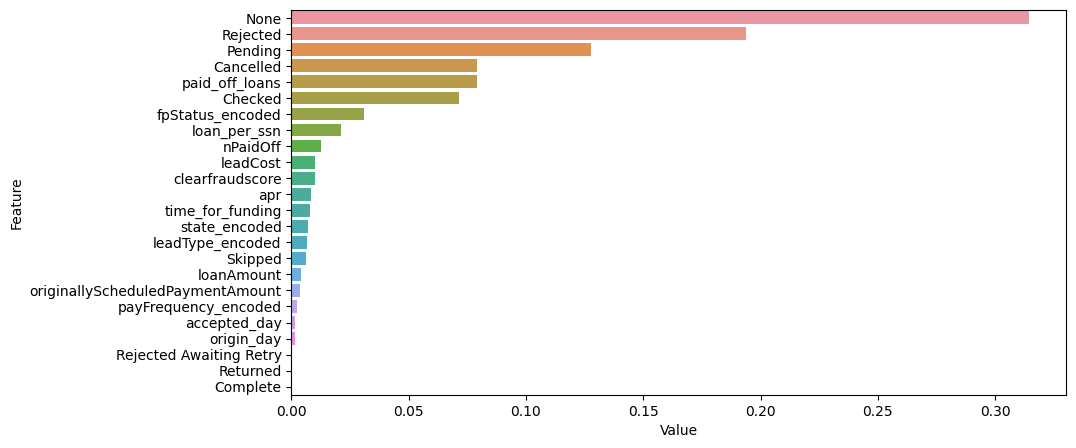

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Random Forest Classifier
model_rf = RandomForestClassifier(n_estimators=20, 
                                  random_state=5, 
                                  criterion='log_loss',
                                  bootstrap=True,                                
                                  max_depth=5,
                                  verbose=0)

# Training the model
model_rf.fit(X_train1, y_train1)

# Predictions
y_pred_rf = model_rf.predict(X_test1)
y_pred_proba_rf = model_rf.predict_proba(X_test1)

# Performance measurement 
auc_score_rf = roc_auc_score(y_test1, y_pred_proba_rf, multi_class='ovr')
print("AUC Score: ", auc_score_rf)
print("Classification Report:\n", classification_report(y_test1, y_pred_rf, zero_division=0))

# Displaying the importance of features
feature_imp_rf = pd.DataFrame(sorted(zip(model_rf.feature_importances_,X_train1.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp_rf.sort_values(by="Value", ascending=False))
plt.show()

From the previous 3 models, it can be deemed that the `RandomForestClassification` model performs the best due to its high AUC score. However, all 3 models have a problem with missing predictions of some of the classes which is due to the imbalance in class distribution. Here we can use a data augmentation technique called 'oversampling' that increases the data instances of minority classes.

In [32]:
# New data set after oversampling
from imblearn.over_sampling import SMOTE

# Recreate dataset that has no NaN values
data_os = data.copy()
data_os['clearfraudscore'] = data_os['clearfraudscore'].fillna(data_os['clearfraudscore'].median())
data_os.isna().values.any()

# Training and Testing dataset definition
feature_data_os = data_os.copy().drop('risk level', axis=1)
target_os = data_os['risk level']

# Creating SMOTE object
oversampler = SMOTE(random_state=5)

# Resampling and oversampling original data 
feature_resampled, target_resampled = oversampler.fit_resample(feature_data_os, target_os)

X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(feature_resampled, 
                                                    target_resampled, 
                                                    test_size = 0.2, 
                                                    stratify=target_resampled)

Cross-validation scores:  [0.88758206 0.88771882 0.89606127 0.88334245 0.88826586]
Mean score:  0.88859409190372
Standard deviation:  0.0041288381552044605
AUC Score:  0.986011695850431
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      2285
           1       0.88      0.87      0.87      2285
           2       0.94      0.93      0.93      2285
           3       0.82      0.91      0.86      2285

    accuracy                           0.90      9140
   macro avg       0.90      0.90      0.90      9140
weighted avg       0.90      0.90      0.90      9140

Consufion Matrix:
 [[2000  115   96   74]
 [  54 1990    5  236]
 [  14   20 2118  133]
 [  17  147   42 2079]]


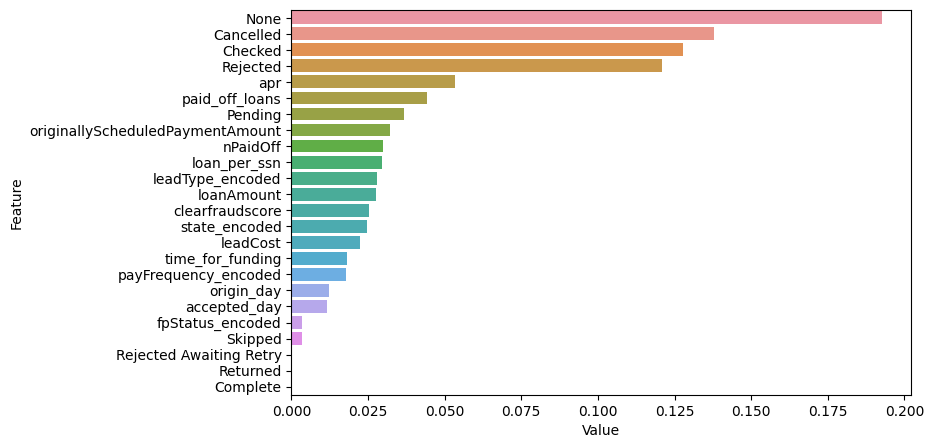

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score


# Random Forest Classifier
model_rf_os = RandomForestClassifier(n_estimators=100, 
                                  random_state=5, 
                                  criterion='log_loss',
                                  bootstrap=True,                                
                                  max_depth=12,
                                  verbose=0)

# Cross-validation
scores_rf_os = cross_val_score(model_rf_os, X_train_os, y_train_os, cv=5)

# Print the cross-validation scores
print("Cross-validation scores: ", scores_rf_os)
print("Mean score: ", scores_rf_os.mean())
print("Standard deviation: ", scores_rf_os.std())

# Training the model
model_rf_os.fit(X_train_os, y_train_os)

# Predictions
y_pred_rf_os = model_rf_os.predict(X_test_os)
y_pred_proba_rf_os = model_rf_os.predict_proba(X_test_os)

# Performance measurement 
auc_score_rf_os = roc_auc_score(y_test_os, y_pred_proba_rf_os, multi_class='ovr')
print("AUC Score: ", auc_score_rf_os)
print("Classification Report:\n", classification_report(y_test_os, y_pred_rf_os, zero_division=0))
print("Consufion Matrix:\n", confusion_matrix(y_test_os, y_pred_rf_os))

# Displaying the importance of features
feature_imp_rf_os = pd.DataFrame(sorted(zip(model_rf_os.feature_importances_,X_train_os.columns)), columns=['Value','Feature'])
plt.figure(figsize=(8, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp_rf_os.sort_values(by="Value", ascending=False))
plt.show()

# Conclusion on prediction model

In conclusion, the random forest prediction model trained on oversampled data was able to achieve an AUC score of 0.984 and an accuracy of 89% on the validation data. This does mean that the classifier performs really well but more testing is needed to prove that it is not an overfit. On the other hand, it is worth noting that the limitations of this classifier is when the input contains null values of which the classifier is not able to make predictions. Moreover, most features that were selected as the training data were qualitatively selected of which important features may be neglected due to the lack of expertise. Lastly, more risk levels can be explored which we can then explore deep neural networks with the final output layer having only one node that gives the probability of default.